In [ ]:
# Enable autoreload in Jupyter
%load_ext autoreload
%autoreload 2

# Imports and Seed Management

We use **fo3d** to visualize LiDAR data as a 3D point cloud.

In [1]:
!uv pip install fiftyone[fo3d]

Using Python 3.11.7 environment at: /home/matti/Master/3. Semester/Hands-on Computer Vision/lab2/project/.venv
Audited 1 package in 9ms


In [12]:
import os

# Set environment variables for reproducibility BEFORE importing torch
os.environ['PYTHONHASHSEED'] = '51'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import sys
from pathlib import Path

# Add project root to sys.path for module imports
PROJECT_ROOT = Path.cwd().parent
sys.path.append(str(PROJECT_ROOT))

import math
from PIL import Image
import numpy as np
import fiftyone as fo
from fiftyone import ViewField as F
import fiftyone.utils.random as four
from fiftyone.utils.huggingface import push_to_hub
from pathlib import Path
import matplotlib.pyplot as plt
import random
import open3d as o3d

from src.utils import set_seeds, get_xyza
from src.visualization import show_class_distribution

set_seeds(51)

All random seeds set to 51 for reproducibility


# Dataset Creation

The existing dataset is removed if it already exists. Please be aware that any additional changes will be lost if the notebook is rerun.

In [3]:
dataset_name = "cilp_assessment"

# Remove existing dataset if it exists
if dataset_name in fo.list_datasets():
    fo.delete_dataset(dataset_name)

dataset = fo.Dataset(dataset_name)
dataset.add_group_field("group", default="rgb")

We load the azimuth and zenith angles to calculate the XYZ positions from the LiDAR data later.

In [4]:
classes = ["cubes", "spheres"]

azimuths, zenith = {}, {}
for label in classes:
    path = Path.cwd().parent / "data" / label
    azimuths[label] = np.load(path / "azimuth.npy")
    zenith[label] = np.load(path / "zenith.npy")


We use two different modalities in the dataset: RGB and LiDAR data. To visualize these data in FiftyOne, the LiDAR data must be converted into visual formats. First, we save the LiDAR data as an RGB image. Next, we transform the LiDAR data into XYZ positions using the azimuth and zenith angles and save the result as a 3D point cloud. For each sample, we create two files and link their file paths to FiftyOne to enable visualization.

For training, we additionally save the XYZ positions as an extra field. This data is used exclusively for LiDAR training.

In [5]:
samples = []

for label in classes:
    rgb_path = Path.cwd().parent / "data" / label / "rgb"
    lidar_path = Path.cwd().parent / "data" / label / "lidar"
    
    lidar_pcd_path = Path.cwd().parent / "data" / label / "lidar_pcd"
    lidar_pcd_path.mkdir(parents=True, exist_ok=True)
    
    lidar_image_path = Path.cwd().parent / "data" / label / "lidar_img"
    lidar_image_path.mkdir(parents=True, exist_ok=True)

    for rgb_file, lidar_file in zip(rgb_path.iterdir(), lidar_path.iterdir()):
        group = fo.Group()
                
        # Save RGB sample
        rgb_sample = fo.Sample(
            filepath=rgb_file,
            group=group.element("rgb"),
            ground_truth=fo.Classification(label=label)
        )
        
        # Convert lidar .npy to .jpg
        arr = np.load(lidar_file)
        lidar_img_file_path = lidar_image_path / lidar_file.name.replace(".npy", ".jpg")
        Image.fromarray(arr.astype(np.uint8)).save(lidar_img_file_path)
        
        lidar_img_sample = fo.Sample(
            filepath=lidar_img_file_path,
            group=group.element("lidar_img"),
            ground_truth=fo.Classification(label=label)
        )
        
        # Create 3D point cloud from lidar .npy
        lidar_xyza = get_xyza(arr, azimuths[label], zenith[label])
        
        # Save Lidar xyza as npy
        lidar_img_sample["xyza"] = lidar_xyza
        
        xyza_points = lidar_xyza.reshape(4, -1).T   # Transpose to get (num_points, 4)
        xyz = xyza_points[:, :3]                    # only XYZ for PCD

        # Create Open3D point cloud
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(xyz)
        
        lidar_pcd_file_path = lidar_pcd_path / lidar_file.name.replace(".npy", ".pcd")
        o3d.io.write_point_cloud(lidar_pcd_file_path, pcd)

        lidar_pcd_sample = fo.Sample(
            filepath=lidar_pcd_file_path,
            group=group.element("lidar_pcd"),
            ground_truth=fo.Classification(label=label)
        )
        
        samples.extend([rgb_sample, lidar_img_sample, lidar_pcd_sample])

To increase training speed, we select 10% of the original data. Because all modalities are ordered consistently, we can select random indices from the first modality and then take the corresponding entries from the other modalities.

In [6]:
# Select 10% of the samples for the dataset
num_samples = len(samples) // 3
idx = np.array(random.sample(range(num_samples), math.ceil(0.1 * num_samples)))
indices = np.concatenate([idx*3, idx*3 + 1, idx*3 + 2]) # include all modalities

dataset.add_samples([samples[i] for i in indices])
print(dataset)

 100% |███████████████| 3228/3228 [1.5s elapsed, 0s remaining, 2.1K samples/s]         
Name:        cilp_assessment
Media type:  group
Group slice: rgb
Num groups:  1076
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    group:            fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.groups.Group)
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    xyza:             fiftyone.core.fields.ArrayField


We compute the metadata to help with visual exploration.

In [7]:
dataset.compute_metadata()

Computing metadata...


 100% |███████████████| 3228/3228 [2.8s elapsed, 0s remaining, 1.2K samples/s]      


Counting the total number of samples per class.

In [8]:
for label in classes:
    label_view = dataset.match(F("ground_truth.label") == label)
    print(f"Number of samples for class {label}:\t {len(label_view):>5}")

Number of samples for class cubes:	  1009
Number of samples for class spheres:	    67


We create a train and validation split.

In [9]:
four.random_split(dataset,
                  {"train": 0.75, "validation": 0.15},
                  # The seed makes the split reproducible
                  seed=51)

tag_counts = dataset.count_sample_tags()
print(f"Tag counts after split: {tag_counts}")

train_view = dataset.match_tags("train")
val_view = dataset.match_tags("validation")

dataset.save()

Tag counts after split: {'validation': 179, 'train': 897}


# Dataset Inspection

Class distribution visualization for the training and validation splits.

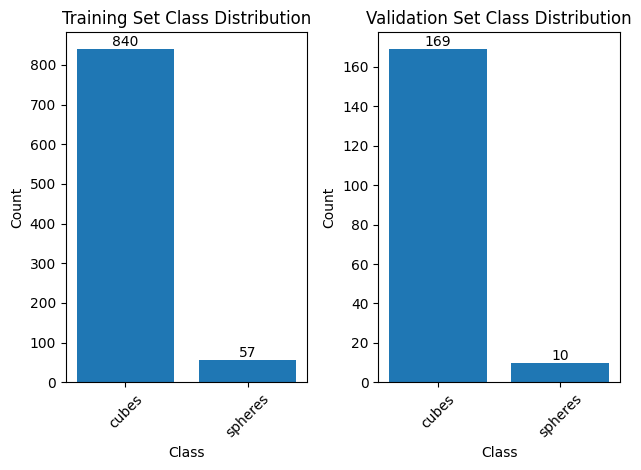

In [17]:
train_class_counts = train_view.count_values("ground_truth.label")

train_labels = list(train_class_counts.keys())
train_values = list(train_class_counts.values())

val_class_counts = val_view.count_values("ground_truth.label")

val_labels = list(val_class_counts.keys())
val_values = list(val_class_counts.values())

# Training set bar chart
ax1 = plt.subplot(1, 2, 1)
show_class_distribution(ax1, train_labels, train_values)

# Validation set bar chart
ax2 = plt.subplot(1, 2, 2)
show_class_distribution(ax2, val_labels, val_values, is_train=False)

plt.tight_layout() 
plt.show()


We inspect image dimensions and data types for every modality.

In [ ]:
sample = dataset.first()
gid = sample.group.id
group_samples = dataset.get_group(gid)

print(f"Number of samples in group {gid}: {len(group_samples)}")
for modality in group_samples:
    if modality == "lidar_pcd":
        print("Skipping lidar_pcd modality (just for visualization)")
        continue

    sample = group_samples[modality]
    print(f"Modality {modality}: Width = {sample.metadata.width}, Height = {sample.metadata.height}")


Number of samples in group 694e4ada2a5cabc4e2e9383c: 3
Modality rgb: Width = 64, Height = 64
Modality lidar_img: Width = 64, Height = 64
Skipping lidar_pcd modality (just for visualization)


Launch app for visual inspection. Screenshots can be found in the *results* folder.

In [ ]:
session = fo.launch_app(dataset)

## Findings

The dataset is very rich in information. In the current visualization, both modalities are shown side by side. The Lidar data is additionally visualized as a 3D point cloud, which provides extra information.

The point cloud makes the ground truth labels very visible and clearly shows the general shape of the objects. The Lidar image data, however, is harder to interpret. The RGB data is particularly challenging to analyze because the images only show a small part of the objects and often omit hidden areas that reveal structural details such as edges and corners. For spheres, corners sometimes appear in the RGB images, even though spheres should have no edges, which indicates a potential labeling or rendering issue.

The difference between sphere and cube RGB images is minimal, while differences in Lidar images are more pronounced. These differences are even more apparent when comparing the 3D representations. In the 3D point cloud, spheres display rounded surfaces and cubes show distinct corners, which are key distinguishing features.

The Lidar data is generally low in noise. Objects are distributed throughout the room, as seen in the 2D projection. Cubes can appear in different rotations, whereas spheres look similar regardless of rotation.

There is a high class imbalance in the dataset, with 1,009 cube instances compared to only 67 spheres.

The images are very similar in resolution and appearance. Additionally, there appears to be no missing data. Depths and sizes vary slightly across the samples, but we did not observe any significant outliers or unexpected data in the inspected samples.

# Export

Export the created dataset in FiftyOne format.

In [ ]:
export_dir = Path.cwd().parent / dataset_name
export_dir.mkdir(parents=True, exist_ok=True)

print(f"Exporting dataset '{dataset_name}' to: {export_dir}")

dataset.export(
    export_dir=str(export_dir),
    dataset_type=fo.types.FiftyOneDataset,  # preserves groups, modalities, metadata, labels, etc.
    overwrite=True,
    progress=True,
)

print("Export finished.")

Exporting dataset 'cilp_assessment' to: /home/matti/Master/3. Semester/Hands-on Computer Vision/lab2/project/cilp_assessment
Exporting samples...
 100% |██████████████████| 3228/3228 [567.2ms elapsed, 0s remaining, 5.7K docs/s]      
Export finished.


Additionally, we save the dataset to the Hugging Face Hub for the submission.

In [ ]:
huggingface_dataset_name = "cilp_assessment"

push_to_hub(dataset, huggingface_dataset_name)

Directory '/tmp/tmp0vixg1zz' already exists; export will be merged with existing files
Exporting samples...
 100% |██████████████████| 3228/3228 [772.6ms elapsed, 0s remaining, 4.2K docs/s]      


HfHubHTTPError: Client error '409 Conflict' for url 'https://huggingface.co/api/repos/create' (Request ID: Root=1-694e4af6-3c9fceaf4311d885385e335c;4f5b9036-0120-4f8a-91d0-6bd1ec7e9ce8)
For more information check: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/409

You already created this dataset repo: CarloColumbo/cilp_assessment